# Grad-ECLIP: Gradient-Enhanced Contrastive Language-Image Pre-training

Ce notebook implémente la méthode Grad-ECLIP pour l'explicabilité des modèles Vision-Language, basée sur l'article de recherche correspondant.

## Objectif

Grad-ECLIP vise à générer des cartes d'attention explicables qui montrent quelles parties d'une image sont importantes pour la prédiction d'un texte donné, en utilisant les gradients des couches d'attention du modèle CLIP.

Let's start with using the open sourced OPENAI CLIP model


In [5]:
#! pip install ftfy regex tqdm
#! pip install git+https://github.com/openai/CLIP.git
#! pip install open_clip_torch


## Installation et Chargement du Modèle CLIP

CLIP (Contrastive Language-Image Pre-training) est un modèle qui apprend des représentations visuelles à partir de descriptions en langage naturel. Il utilise un encodeur d'image (Vision Transformer) et un encodeur de texte pour créer un espace d'embedding commun.

**Architecture CLIP utilisée :**

- **Vision Transformer (ViT-B/16)** : Découpe l'image en patches de 16x16 pixels
- **Encodeur de texte** : Transformeur pour traiter les descriptions textuelles
- **Projection commune** : Espace latent partagé pour images et textes

**Fonction objective CLIP :**
$$\mathcal{L}_{CLIP} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{\exp(\text{sim}(z_i^v, z_i^t) / \tau)}{\sum_{j=1}^{N} \exp(\text{sim}(z_i^v, z_j^t) / \tau)}$$

où $z_i^v$ et $z_i^t$ sont les représentations normalisées de l'image et du texte, et $\tau$ est le paramètre de température.


In [6]:
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip
from open_clip import create_model_from_pretrained


import cv2
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
clipmodel, preprocess = clip.load("ViT-B/16", device=device)
clip_inres = clipmodel.visual.input_resolution
clip_ksize = clipmodel.visual.conv1.kernel_size

print("[clip resolution]:", clip_inres)
print("[clip kernel size]:", clip_ksize)

[clip resolution]: 224
[clip kernel size]: (16, 16)


## Fonctionnement de base de Grad-ECLIP

### Le problème de l'explicabilité dans CLIP

Les modèles Vision-Language comme CLIP sont puissants mais fonctionnent comme des "boîtes noires". L'article Grad-ECLIP propose une méthode pour rendre les prédictions de CLIP explicables par:

1. L'identification des régions d'intérêt dans une image qui conduisent à une prédiction particulière
2. La mise en évidence des associations entre le texte et les éléments visuels

CLIP utilise un token spécial [CLS] pour représenter l'image entière, mais cette représentation globale ne permet pas d'expliquer quelles parties de l'image sont importantes pour l'association avec un texte donné.

### Principe fondamental de Grad-ECLIP

Grad-ECLIP propose d'utiliser les gradients des mécanismes d'attention du Vision Transformer pour générer des cartes d'explicabilité. L'intuition est la suivante:

- Les couches d'attention captent les relations entre les différents patches de l'image
- Les gradients indiquent comment chaque patch influence le score de similarité final
- La combinaison des poids d'attention avec leurs gradients révèle l'importance de chaque région

Mathématiquement, cela revient à calculer:

$$M_{\text{Grad-ECLIP}} = \sum_{l=1}^{L} \left|\frac{\partial \mathcal{L}}{\partial A^{(l)}}\right| \odot A^{(l)}$$

où $A^{(l)}$ sont les poids d'attention de la couche $l$ et $\mathcal{L}$ est la fonction de perte basée sur la similarité texte-image.


## Préprocessing des Images

Le préprocessing est crucial pour Grad-ECLIP car il doit préserver la structure spatiale des features pour calculer les gradients correctement.

**Éléments clés :**

1. **Redimensionnement adaptatif** : Ajustement de la taille selon les patches du ViT
2. **Normalisation CLIP** : Utilisation des statistiques d'entraînement de CLIP
3. **Préservation du ratio** : Important pour maintenir la cohérence spatiale

**Transformation des patches :**
$$P_{i,j} = \text{Patch}(I, (i \cdot p, j \cdot p, (i+1) \cdot p, (j+1) \cdot p))$$

où $I$ est l'image d'entrée, $p$ est la taille du patch (16×16), et $(i,j)$ sont les coordonnées du patch.


In [7]:
_transform = Compose([
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073),
              (0.26862954, 0.26130258, 0.27577711)),
])


def imgprocess(img, patch_size=[16, 16], scale_factor=1):
    w, h = img.size
    ph, pw = patch_size
    nw = int(w * scale_factor / pw + 0.5) * pw
    nh = int(h * scale_factor / ph + 0.5) * ph

    ResizeOp = Resize((nh, nw), interpolation=InterpolationMode.BICUBIC)
    img = ResizeOp(img).convert("RGB")
    return _transform(img)


def visualize(map, raw_image, resize):
    image = np.asarray(raw_image.copy())
    map = resize(map.unsqueeze(0))[0].cpu().numpy()
    color = cv2.applyColorMap(
        (map*255).astype(np.uint8), cv2.COLORMAP_JET)  # cv2 to plt
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

## Théorie de l'Attention dans Grad-ECLIP

### Mécanisme d'Attention Multi-Têtes

L'attention dans CLIP suit la formule standard du Transformer :

$$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Où :

- $Q$ (Query) : représentation de ce qu'on cherche
- $K$ (Key) : représentation de ce qu'on a disponible
- $V$ (Value) : information à récupérer
- $d_k$ : dimension des clés (pour la normalisation)

### Innovation de Grad-ECLIP

Grad-ECLIP utilise les **gradients de l'attention** pour identifier quelles parties de l'image contribuent le plus à la similarité texte-image.

**Formule du gradient d'attention :**
$$\frac{\partial \mathcal{L}}{\partial A_{i,j}} = \frac{\partial \mathcal{L}}{\partial s} \cdot \frac{\partial s}{\partial A_{i,j}}$$

où $A_{i,j}$ est le poids d'attention entre le patch $i$ et le token $j$, et $s$ est le score de similarité CLIP.

**Carte d'explicabilité finale :**
$$M_{\text{grad}} = \sum_{l=1}^{L} \sum_{h=1}^{H} \left|\frac{\partial \mathcal{L}}{\partial A^{(l,h)}}\right| \odot A^{(l,h)}$$

où $L$ est le nombre de couches, $H$ le nombre de têtes d'attention.


In [8]:
def attention_layer(q, k, v, num_heads=1):
    "Compute 'Scaled Dot Product Attention'"
    tgt_len, bsz, embed_dim = q.shape
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5
    q = q * scaling

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)
    attn_output_heads = torch.bmm(attn_output_weights, v)
    assert list(attn_output_heads.size()) == [
        bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output_heads.transpose(
        0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, -1)
    attn_output_weights = attn_output_weights.sum(dim=1) / num_heads
    return attn_output, attn_output_weights

## Implémentation de l'Attention dans Grad-ECLIP

La fonction `attention_layer` ci-dessus réimplémente le mécanisme d'attention standard des Transformers pour permettre le calcul des gradients. Cette implémentation est essentielle pour Grad-ECLIP car elle:

1. Permet d'accéder aux matrices Q, K et V qui servent au calcul de l'attention
2. Donne accès aux poids d'attention originaux (`attn_output_weights`)
3. Maintient le graphe de calcul qui permettra de calculer les gradients

Dans l'article Grad-ECLIP, les auteurs définissent l'attention comme:

$$A = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)$$

Puis ils utilisent ces poids d'attention pour calculer la sortie:

$$O = AV$$

Notre implémentation suit exactement ce schéma:

- Mise à l'échelle des requêtes: `q = q * scaling`
- Calcul des poids d'attention: `attn_output_weights = torch.bmm(q, k.transpose(1, 2))`
- Application du softmax: `attn_output_weights = F.softmax(attn_output_weights, dim=-1)`
- Calcul de la sortie: `attn_output_heads = torch.bmm(attn_output_weights, v)`

Cette réimplémentation est cruciale car elle permet de conserver les informations intermédiaires (Q, K, V, A) nécessaires pour calculer les gradients utilisés dans Grad-ECLIP.


### Encodage Dense pour l'Explicabilité

#### Différence avec l'Encodage Standard

- **CLIP standard** : Ne retourne que l'embedding du token [CLS]
- **Grad-ECLIP** : Retourne les embeddings de **tous les patches** de l'image

### Composants Clés Implémentés :

1. **Position Embedding Adaptatif** : Interpolation bicubique pour s'adapter à différentes résolutions
2. **Extraction des Couches Intermédiaires** : Accès aux n dernières couches d'attention
3. **Sauvegarde des Gradients** : Conservation de Q, K, V pour le calcul des gradients

**Position Embedding Interpolation :**
$$\text{PE}_{\text{new}}(x,y) = \text{BiCubic}(\text{PE}_{\text{orig}}, \frac{x \cdot H_{\text{orig}}}{H_{\text{new}}}, \frac{y \cdot W_{\text{orig}}}{W_{\text{new}}})$$

**Encodage dense des patches :**
$$Z_{\text{dense}} = \text{LayerNorm}(\text{PE} + \text{Linear}(\text{Flatten}(P_1, P_2, ..., P_N)))$$

où $P_i$ représente le $i$-ème patch de l'image.

**Extraction des features multi-couches :**
$$F^{(l)} = \text{TransformerBlock}^{(l)}(F^{(l-1)})$$
$$\text{Features} = \text{Concat}([F^{(L-n+1)}, F^{(L-n+2)}, ..., F^{(L)}])$$

où $n$ est le nombre de dernières couches utilisées pour l'explicabilité.


### Encodage Dense pour l'Explicabilité

#### Différence avec l'Encodage Standard

- **CLIP standard** : Ne retourne que l'embedding du token [CLS]
- **Grad-ECLIP** : Retourne les embeddings de **tous les patches** de l'image

#### Composants Clés Implémentés :

1. **Position Embedding Adaptatif** : Interpolation bicubique pour s'adapter à différentes résolutions
2. **Extraction des Couches Intermédiaires** : Accès aux n dernières couches d'attention
3. **Sauvegarde des Gradients** : Conservation de Q, K, V pour le calcul des gradients

**Position Embedding Interpolation :**
$$\text{PE}_{\text{new}}(x,y) = \text{BiCubic}(\text{PE}_{\text{orig}}, \frac{x \cdot H_{\text{orig}}}{H_{\text{new}}}, \frac{y \cdot W_{\text{orig}}}{W_{\text{new}}})$$

**Encodage dense des patches :**
$$Z_{\text{dense}} = \text{LayerNorm}(\text{PE} + \text{Linear}(\text{Flatten}(P_1, P_2, ..., P_N)))$$

où $P_i$ représente le $i$-ème patch de l'image.

**Extraction des features multi-couches :**
$$F^{(l)} = \text{TransformerBlock}^{(l)}(F^{(l-1)})$$
$$\text{Features} = \text{Concat}([F^{(L-n+1)}, F^{(L-n+2)}, ..., F^{(L)}])$$

où $n$ est le nombre de dernières couches utilisées pour l'explicabilité.

In [9]:
def clip_encode_dense(x, n):
    vision_width = clipmodel.visual.transformer.width
    vision_heads = vision_width // 64
    print("[vision_width and vision_heads]:", vision_width, vision_heads)

    # modified from CLIP
    x = x.half()
    x = clipmodel.visual.conv1(x)
    feah, feaw = x.shape[-2:]

    x = x.reshape(x.shape[0], x.shape[1], -1)
    x = x.permute(0, 2, 1)
    class_embedding = clipmodel.visual.class_embedding.to(x.dtype)
    x = torch.cat(
        [class_embedding + torch.zeros(x.shape[0], 1, x.shape[-1]).to(x), x], dim=1)

    # scale position embedding as the image w-h ratio
    pos_embedding = clipmodel.visual.positional_embedding.to(x.dtype)
    tok_pos, img_pos = pos_embedding[:1, :], pos_embedding[1:, :]
    pos_h = clip_inres // clip_ksize[0]
    pos_w = clip_inres // clip_ksize[1]
    assert img_pos.size(0) == (
        pos_h * pos_w), f"the size of pos_embedding ({img_pos.size(0)}) does not match resolution shape pos_h ({pos_h}) * pos_w ({pos_w})"
    img_pos = img_pos.reshape(
        1, pos_h, pos_w, img_pos.shape[1]).permute(0, 3, 1, 2)
    print("[POS shape]:", img_pos.shape, (feah, feaw))
    img_pos = torch.nn.functional.interpolate(img_pos, size=(
        feah, feaw), mode='bicubic', align_corners=False)
    img_pos = img_pos.reshape(1, img_pos.shape[1], -1).permute(0, 2, 1)
    pos_embedding = torch.cat((tok_pos[None, ...], img_pos), dim=1)
    x = x + pos_embedding
    x = clipmodel.visual.ln_pre(x)

    x = x.permute(1, 0, 2)  # NLD -> LND
    x = torch.nn.Sequential(*clipmodel.visual.transformer.resblocks[:-n])(x)

    attns = []
    atten_outs = []
    vs = []
    qs = []
    ks = []
    for TR in clipmodel.visual.transformer.resblocks[-n:]:
        x_in = x
        x = TR.ln_1(x_in)
        linear = torch._C._nn.linear
        q, k, v = linear(x, TR.attn.in_proj_weight,
                         TR.attn.in_proj_bias).chunk(3, dim=-1)
        attn_output, attn = attention_layer(q, k, v, 1)  # vision_heads=1
        attns.append(attn)
        atten_outs.append(attn_output)
        vs.append(v)
        qs.append(q)
        ks.append(k)

        x_after_attn = linear(
            attn_output, TR.attn.out_proj.weight, TR.attn.out_proj.bias)
        x = x_after_attn + x_in
        x = x + TR.mlp(TR.ln_2(x))

    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clipmodel.visual.ln_post(x)
    x = x @ clipmodel.visual.proj
    return x, x_in, vs, qs, ks, attns, atten_outs, (feah, feaw)

## Encodage Dense et Position Embedding dans Grad-ECLIP

L'encodage dense est un concept fondamental dans Grad-ECLIP, car il permet de maintenir la correspondance spatiale entre les features et les régions de l'image originale.

### Pourquoi l'Encodage Dense est nécessaire

Dans le CLIP original, seul le token [CLS] est utilisé pour la classification, ce qui ne permet pas une localisation précise des concepts dans l'image. L'article Grad-ECLIP propose d'utiliser tous les tokens de patch pour construire une carte d'explicabilité dense.

### Position Embedding Adaptatif

La fonction `clip_encode_dense` implémente une technique d'interpolation des embeddings positionnels, essentielle pour adapter le modèle à différentes résolutions d'images:

1. Le modèle CLIP original a été entraîné avec une résolution fixe (224×224 pixels)
2. Pour des images de tailles différentes, nous devons adapter les embeddings positionnels
3. L'interpolation bicubique permet de préserver les relations spatiales entre les patches

L'équation dans l'article:
$$\text{PE}_{\text{interpolated}} = \text{Interpolate}(\text{PE}_{\text{original}}, H_{\text{new}}, W_{\text{new}})$$

est implémentée par:
```python
img_pos = torch.nn.functional.interpolate(img_pos, size=(feah, feaw), mode='bicubic', align_corners=False)

Cette adaptation est cruciale car elle permet au modèle de traiter correctement les informations spatiales pour des images de diverses tailles.

## 4. Chargement et affichage de l'image, préparation des textes

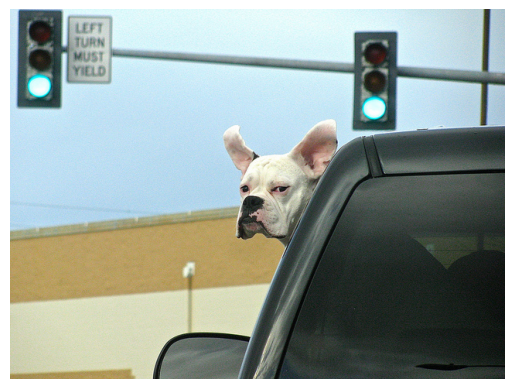

In [10]:
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

img_path = "./dog_and_car.png"
img = Image.open(img_path).convert("RGB")
texts = ["dog", "car", "traffic lights", "a dog in a car waiting for traffic lights"] 

# url = "http://l7.alamy.com/zooms/1e7674256f464050bf142a5d21407ede/single-cowboy-guiding-a-line-of-horses-through-the-desert-bnh6m3.jpg"
# img = Image.open(urlopen(url))
# texts = ["cowboy", "horse", "desert", "single cowboy guiding a line of horses through the desert"]

plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
# preprocess image and text
img_preprocessed = preprocess(img).cuda().unsqueeze(0)
text_processed = clip.tokenize(texts).cuda()
# extract text featrue
text_embedding = clipmodel.encode_text(text_processed)
text_embedding = F.normalize(text_embedding, dim=-1)
print("[text embedding]:", text_embedding.shape)

ori_img_embedding = clipmodel.encode_image(img_preprocessed)
ori_img_embedding = F.normalize(ori_img_embedding, dim=-1)
print("[image embedding]:", ori_img_embedding.shape)

cosine = (ori_img_embedding @ text_embedding.T)
print("[cosine]:", cosine)

[text embedding]: torch.Size([4, 512])
[image embedding]: torch.Size([1, 512])
[cosine]: tensor([[0.2681, 0.2378, 0.2605, 0.3506]], device='cuda:0',
       dtype=torch.float16, grad_fn=<MmBackward0>)


In [12]:
img_preprocessed_k = imgprocess(img).cuda().unsqueeze(0)
#
# x, vs, qs, ks, attns, atten_outs, (feah, feaw)
outputs, last_feat, vs, qs, ks, attns, atten_outs, map_size = clip_encode_dense(
    img_preprocessed_k, n=1)
img_embedding = F.normalize(outputs[:, 0], dim=-1)
print("[image embedding]:", img_embedding.shape)
cosine = (img_embedding @ text_embedding.T)[0]
print("cosine:", cosine)

# similarity between text prompt and patch features
p_final = F.normalize(outputs[:, 1:], dim=-1)
cosine_p = (
    p_final @ text_embedding.T)[0].transpose(1, 0).reshape(-1, *map_size)
print("[position similarity (cosine p)]:", cosine_p.shape)

[vision_width and vision_heads]: 768 12
[POS shape]: torch.Size([1, 768, 14, 14]) (30, 40)
[image embedding]: torch.Size([1, 512])
cosine: tensor([0.1901, 0.2028, 0.2117, 0.1715], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
[position similarity (cosine p)]: torch.Size([4, 30, 40])


## Implémentation de Grad-ECLIP

### Algorithme Principal

1. **Forward Pass** : Encodage dense de l'image et du texte
2. **Calcul de Similarité** : Score CLIP entre image et texte
3. **Backward Pass** : Calcul des gradients par rapport aux poids d'attention
4. **Agrégation** : Combinaison des gradients et des poids d'attention
5. **Visualisation** : Génération de la carte de chaleur

### Étapes Mathématiques :

**1. Similarité CLIP :**
$$ s = \frac{f_I \cdot f_T}{||f_I|| \cdot ||f_T||}$$

**2. Loss pour les gradients :**
$$\mathcal{L} = -\log(s)$$ ou
$$\mathcal{L} = 1 - s $$

**3. Gradients d'attention :**
$$G^{(l,h)}_{i,j} = \frac{\partial \mathcal{L}}{\partial A^{(l,h)}_{i,j}}$$

**4. Carte d'attention finale :**
$$M = \text{Reshape}\left(\sum_{l,h} |G^{(l,h)}| \odot A^{(l,h)}\right)$$


In [13]:
# generate ODAM map

def sim_qk(q, k):
    q_cls = F.normalize(q[:1, 0, :], dim=-1)
    k_patch = F.normalize(k[1:, 0, :], dim=-1)

    cosine_qk = (q_cls * k_patch).sum(-1)
    cosine_qk_max = cosine_qk.max(dim=-1, keepdim=True)[0]
    cosine_qk_min = cosine_qk.min(dim=-1, keepdim=True)[0]
    cosine_qk = (cosine_qk-cosine_qk_min) / (cosine_qk_max-cosine_qk_min)
    return cosine_qk


def grad_eclip(c, qs, ks, vs, attn_outputs, map_size):
    # gradient on last attention output
    tmp_maps = []
    for q, k, v, attn_output in zip(qs, ks, vs, attn_outputs):
        grad = torch.autograd.grad(
            c,
            attn_output,
            retain_graph=True)[0]

        grad_cls = grad[:1, 0, :]
        v_patch = v[1:, 0, :]
        cosine_qk = sim_qk(q, k).reshape(-1)
        tmp_maps.append((grad_cls * v_patch * cosine_qk[:, None]).sum(-1))

    emap = F.relu_(torch.stack(tmp_maps, dim=0)).sum(0)
    return emap.reshape(*map_size)


def self_attn(attns, map_size):
    attn_patch = attns[-1][0, :1, 1:].reshape(*map_size)
    print("[attn of cls token on lastv]:", attn_patch.shape)
    return attn_patch


def grad_cam(c, feat, map_size):
    # GRAD-CAM: use the feature outputs of the final attention layer
    grad = torch.autograd.grad(
        c,
        feat,
        retain_graph=True)[0]
    grad_weight = grad.mean(0, keepdim=True)
    grad_cam = F.relu_((grad_weight * feat).sum(-1))
    grad_cam = grad_cam[1:].reshape(*map_size)
    return grad_cam

['dog', 'car', 'traffic lights', 'a dog in a car waiting for traffic lights']


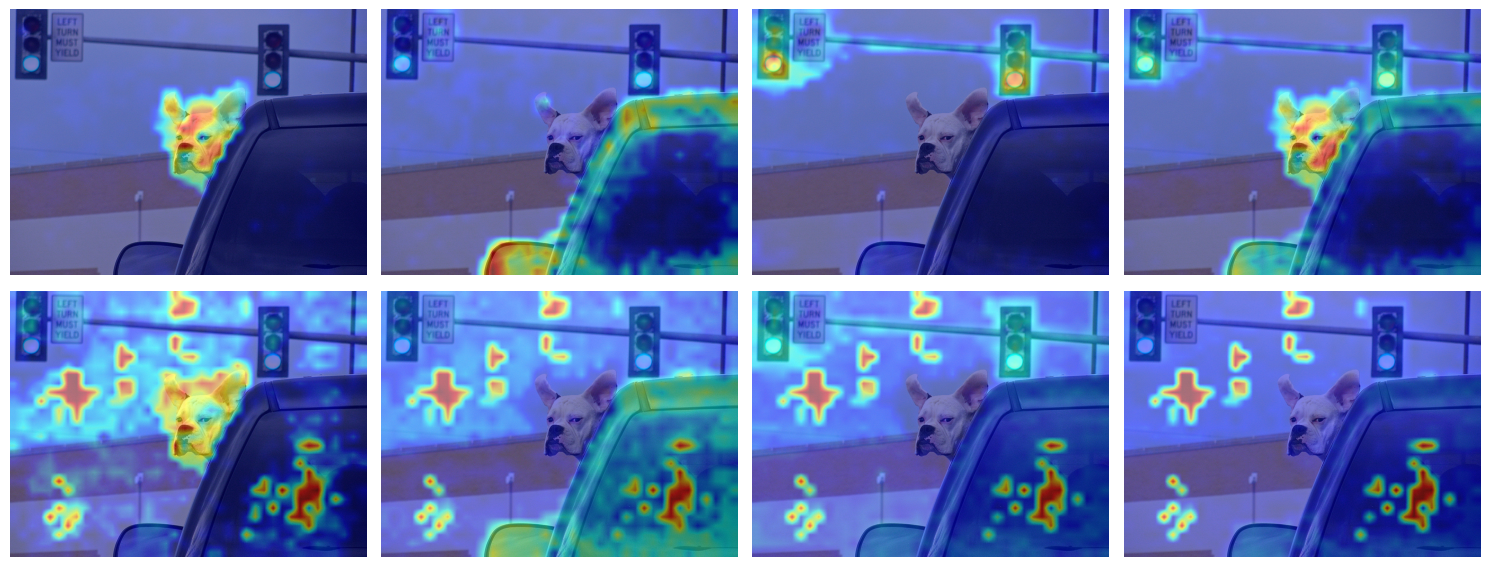

In [14]:
grad_emaps = []
grad_cams = []
for i, c in enumerate(cosine):
    grad_emaps.append(grad_eclip(c, qs, ks, vs, atten_outs, map_size))
    grad_cams.append(grad_cam(c, last_feat, map_size))

print(texts)
h, w = img.size
resize = T.Resize((w, h))
fig, axs = plt.subplots(ncols=len(cosine), nrows=2, figsize=(15, 6))
for i, ax in enumerate(axs.T):
    tmp = grad_emaps[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax[0].axis('off')
    ax[0].imshow(c_ret)

    tmp = grad_cams[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax[1].axis('off')
    ax[1].imshow(c_ret)

fig.tight_layout()